# Reading characters on a document
**1)Preprocessing to detect the edges of the document** <br>

Read the image, <br>
Convert the image to grayscale, <br>
Blur it by applying Gaussian Blur, (5,5) Kernel is used.<br>
Find the edges by using Canny Edge Detector,

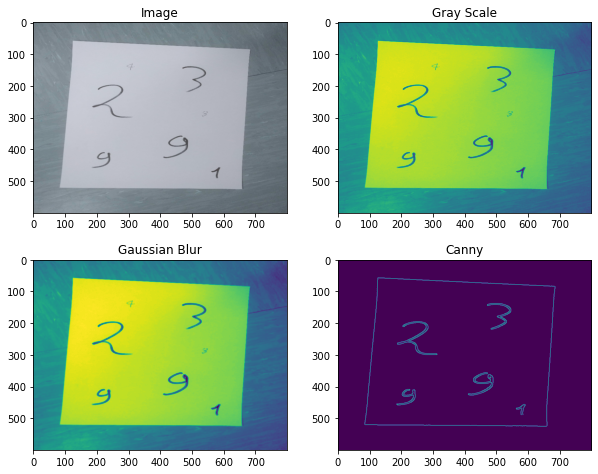

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import combinations
from math import sin, cos, atan
from sklearn.cluster import KMeans

image = cv2.imread("set1/set1_img5.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = cv2.resize(image, (800,600))
 
gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray1, (5, 5), 0)
edged = cv2.Canny(gray, 50, 200)
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
ax1.imshow(image)
ax1.set_title("Image")
ax2.imshow(gray1)
ax2.set_title("Gray Scale")
ax3.imshow(gray)
ax3.set_title("Gaussian Blur")
ax4.imshow(edged)
ax4.set_title("Canny")

plt.show()

**2)Use HoughLines to detect straight lines.**<br>

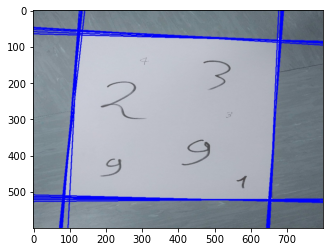

In [6]:
lines = cv2.HoughLines(edged, 2, (np.pi / 360),  100)

for line in lines:
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    n = 5000
    x1 = int(x0 + n * (-b))
    y1 = int(y0 + n * (a))
    x2 = int(x0 - n * (-b))
    y2 = int(y0 - n * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
cv2.imshow('res', edged)
cv2.imshow('res2', image)
#cv2.imwrite('houghLine.jpg', image)
cv2.waitKey()
cv2.destroyAllWindows()  

#plt.imshow(cv2.imread("houghLine.jpg"))

Function **_get_angle_between_lines** will be to calculate the angle between the lines.
Finds the slope of each line m1 and m2, the arctan of the equation 
((m2-m1) / (1 + m2 * m1)) gives the angle between two lines

Function **_intersection** will be used to detect the intersection of the HoughLines, some of the intersection
points will be corner point as vertices of the document.

In [3]:
def _get_angle_between_lines(line_1, line_2):
    rho1, theta1 = line_1
    rho2, theta2 = line_2
    m1 = -(np.cos(theta1) / np.sin(theta1))
    m2 = -(np.cos(theta2) / np.sin(theta2))
    return abs(atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi)

def _intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    
    A = np.array([[np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

intersections = []
group_lines = combinations(range(len(lines)), 2)
x_in_range = lambda x: 0 <= x <= image.shape[1]
y_in_range = lambda y: 0 <= y <= image.shape[0]

for i, j in group_lines:
    line_i, line_j = lines[i][0], lines[j][0]
            
    if 80.0 < _get_angle_between_lines(line_i, line_j) < 100.0:
        int_point = _intersection(line_i, line_j)
                
        if x_in_range(int_point[0][0]) and y_in_range(int_point[0][1]): 
            intersections.append(int_point)


To find the center of the intersection points, **KMeans algorithm** used so that we claim **4 intersection points** as edges

In [4]:
X = np.array([[point[0][0], point[0][1]] for point in intersections])
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0).fit(X)

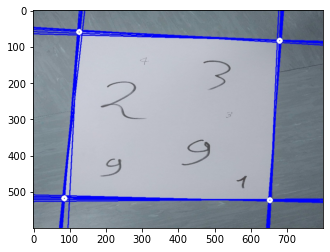

In [5]:
for idx, line in enumerate(lines):
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    n = 5000
    x1 = int(x0 + n * (-b))
    y1 = int(y0 + n * (a))
    x2 = int(x0 - n * (-b))
    y2 = int(y0 - n * (a))

    cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)
        
for point in kmeans.cluster_centers_:
    x, y = point

    cv2.circle(image,(int(x), int(y)), 5,(255, 255, 255),5 )

    cv2.imshow("image", image)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
#cv2.imwrite('intersection.jpg', image)
cv2.waitKey()
cv2.destroyAllWindows()  

#plt.imshow(cv2.imread("intersection.jpg"))

With the function **_order_points**, initialize the edges to warp the image and returns the coordinates. <br>
Rect coordinates are topLeft, topRight, bottomLeft, bottomRight in order.

In [50]:
def _order_points(pts):

    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
        
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
        
    return rect

To compute the width, distance between (bottomRight - bottomLeft) must be maximum, <br>
to compute the height, distance between (topRight - bottomRight) must be maximum <br>

Perspective transform matrix used to transform rect coordinates to dst coordinates which will be <br>
[0,0], top left <br>
[maxWidth, 0], top right <br>
[0,maxHeight], bottom left <br>
[maxWidth, maxHeight], bottom right

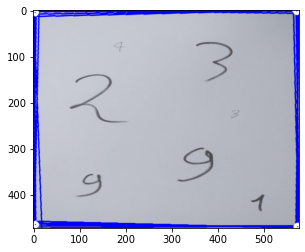

In [51]:
pts = np.array([(x, y) 
        for intersection in intersections
            for x, y in intersection
        ])
rect = _order_points(pts)
(tl, tr, br, bl) = rect

widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))


dst = np.array([
    [0, 0],                         
    [maxWidth - 0.001, 0],              
    [maxWidth - 0.001, maxHeight - 0.001],  
    [0, maxHeight - 0.001]],            
    dtype = "float32"               
        )

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

#cv2.imshow("image", warped)
#plt.imshow(warped)

Once again, preprocessing to the warped image before it is segmented to its characters. <br>
GrayScale conversion, BilateralFiltering and CannyEdgeDetection is used.

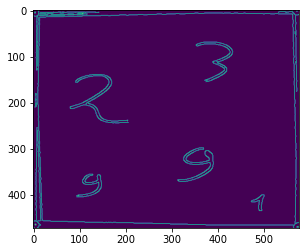

In [52]:
g_img = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
b_img = cv2.bilateralFilter(g_img, 9, 70, 10)
ce_img = cv2.Canny(b_img, 20, 200)

#plt.imshow(ce_img)

**2)Character Segmentation** <br><br>
a. Filtering
    - Redundant Lines Removal (Remova horizontal and verical lines),
    - Blob Removal
b. Find Contours

In [53]:
from skimage import morphology

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
remove_horizontal = cv2.morphologyEx(ce_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=8)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(ce_img, [c], -1, (0, 0, 0), 5)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 20))
    remove_vertical = cv2.morphologyEx(ce_img, cv2.MORPH_OPEN, vertical_kernel, iterations=8)
    cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(ce_img, [c], -1, (0, 0, 0), 5)


br_img = morphology.remove_small_objects(ce_img.astype(bool), min_size=50,
                                                     connectivity=3).astype(int)
mask_x, mask_y = np.where(br_img == 0)
ce_img[mask_x, mask_y] = 0


contours, hierarchy = cv2.findContours(ce_img.copy(), cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])


Draw boundaries as rectangles which has the minimum size (w,h) includes the character, <br>
for each separated characters in the image

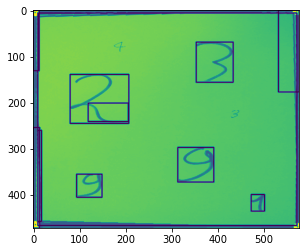

In [68]:
List_w = []
List_h = []  
List_cropped = []

for i, ctr in enumerate(sorted_contours):
    x, y, w, h = cv2.boundingRect(ctr)

    roi = g_img[y:y + h, x:x + w]
    area = w * h
    perimeter = 2 * (w + h)
    aspect_ratio = w / h

    if 1000 < area:
        rect = cv2.rectangle(g_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        crop_img = g_img[y:y + h, x:x + w]
        List_cropped.append(crop_img)

        List_w.append(w)
        List_h.append(h)

        cv2.imshow("Image", g_img)
        cv2.imshow("Canny Edge", ce_img)
        cv2.imshow('rect', rect)
        cv2.imshow("Cropped Characters", crop_img)

        cv2.imwrite("cropped_img.jpg",rect)

    cv2.waitKey()
    cv2.destroyAllWindows()

#plt.imshow(rect)

The list, **List_resized**, holds the segmented characters and **resize** all of them to prepare for recognition step.
Also before comparison, apply **binarization** to each character.

In [69]:
List_resized = []
for i in range(len(List_cropped)):
    x = cv2.resize(List_cropped[i], (28 , 28))
    List_resized.append(x)

**3) Character Recognition**

To determine the character, a model which is trained by using MNIST dataset with Convnet model, used.
First, features(train and test images) scaled to (28,28) and normalized.
And then, model is built by using various layers.

But yet, the model is not working well.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# feature scaling and normalization
training_images = X_train.reshape((60000, 28 , 28,1)).astype('float32') / 255
training_targets = to_categorical(y_train)

test_images = X_test.reshape((10000, 28 , 28,1)).astype('float32') / 255
test_targets = to_categorical(y_test)

input_shape = (training_images.shape[1],)

# building the model
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_targets, validation_split=0.3, callbacks=[EarlyStopping(patience=2)], epochs=10)



Epoch 1/10
1313/1313 [==============================] - 69s 53ms/step - loss: 0.1815 - accuracy: 0.9431 - val_loss: 0.0624 - val_accuracy: 0.9818
Epoch 2/10
1313/1313 [==============================] - 52s 39ms/step - loss: 0.0525 - accuracy: 0.9836 - val_loss: 0.0533 - val_accuracy: 0.9832
Epoch 3/10
1313/1313 [==============================] - 52s 40ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0423 - val_accuracy: 0.9868
Epoch 4/10
1313/1313 [==============================] - 53s 40ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.0417 - val_accuracy: 0.9880
Epoch 5/10
1313/1313 [==============================] - 50s 38ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0449 - val_accuracy: 0.9872
Epoch 6/10
1313/1313 [==============================] - 55s 42ms/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.0477 - val_accuracy: 0.9862


In [73]:
def predict(image):
    input = cv2.resize(image, (28 , 28)).reshape((28 , 28,1)).astype('float32') / 255
    return model.predict_classes(np.array([input]))

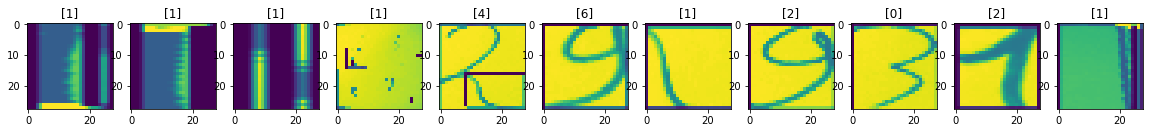

In [75]:
plt.figure(figsize=(20,10))
columns = len(List_resized)
for i, image in enumerate(List_resized):
    plt.subplot(len(List_resized) / columns + 1, columns, i + 1)
    plt.imshow(List_resized[i])
    prediction = predict(List_resized[i])
    plt.title(prediction)